### Load in Data

In [1]:
import pandas as pd
import glob

# Get a list of all cringe csv files
cringe_list = glob.glob('Dataset(.csv)/CringeData/*.csv')
cringe_list_size = len(cringe_list)

# Initalize dataframe which will hold mergedcsv files
cringeDF = pd.DataFrame()

# Go through list and give each file a videoID and label of 0
for i in range(0, cringe_list_size):
    tempDF = pd.read_csv(cringe_list[i])
    tempDF['video_id'] = str(i) + 'c'
    tempDF['label'] = 0
    
    # Merge file into cringeDF
    cringeDF= cringeDF.append(tempDF, sort=True)
    
    # Reset index
    cringeDF.reset_index()

    
# Get a list of all pain csv files
pain_list = glob.glob('Dataset(.csv)/PainData/*.csv')
pain_list_size = len(pain_list)

# Initialize dataframe which will hold merged csv files
painDF = pd.DataFrame()

# Go through list and give each file a videoID and label of 1
for i in range(0, pain_list_size):
    tempDF = pd.read_csv(pain_list[i])
    tempDF['video_id'] = str(i) + 'p'
    tempDF['label'] = 1
    
    # Merge file into cringeDF
    painDF= painDF.append(tempDF, sort=True)
    
    # Reset index
    painDF.reset_index()
            

### Clean Data 

In [2]:
from sklearn.preprocessing import StandardScaler

# Filter out unsuccessful and low confidence frames
cringeDF = cringeDF.loc[cringeDF['confidence'] > 0.8]
cringeDF = cringeDF.loc[cringeDF['success'] == 1]

painDF = painDF.loc[painDF['confidence'] > 0.8] 
painDF = painDF.loc[painDF['success'] == 1]

# Merge all csv entries and all cols
combinedDF = cringeDF.append(painDF, sort= True)
combinedDF = combinedDF.reset_index()

### View AU Intensity Differences

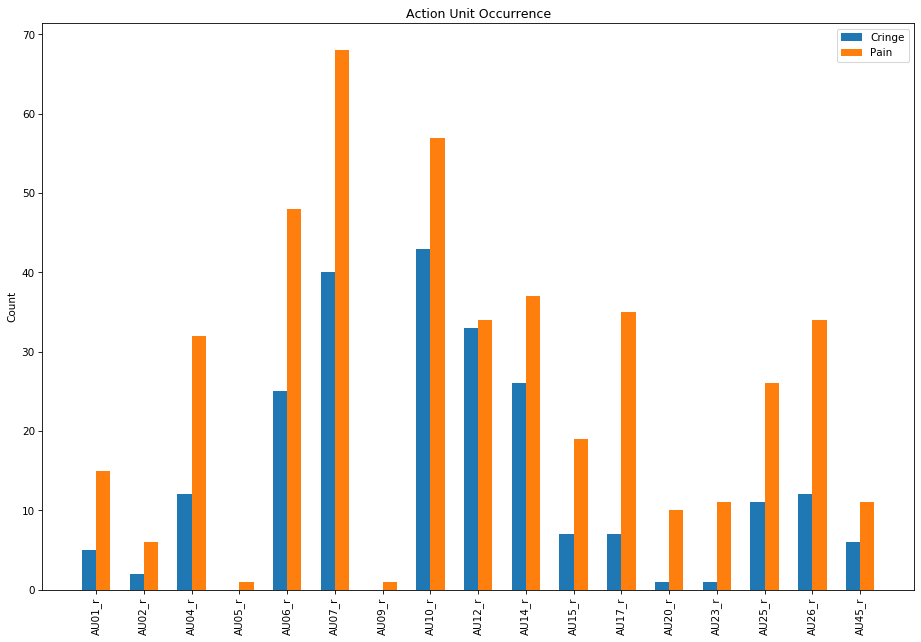

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Inspiration from https://www.youtube.com/watch?v=l11iy6SSUCY&ab_channel=SFURosieLab
# Get the max AU intenisty per AU per video
feature_list = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
                'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
                'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'video_id']

cringeFeaturesDF = cringeDF.loc[:,feature_list]
painFeaturesDF = painDF.loc[:,feature_list]

# Get max AU intensity for each video
cringeMaxAU = cringeFeaturesDF.groupby('video_id').max()
painMaxAU = painFeaturesDF.groupby('video_id').max() 

# Total number of times the AU was above 2
cringeAUs = (cringeMaxAU > 2).sum()
painAUs = (painMaxAU > 2).sum()

# Set our x axis 
x1 = cringeAUs.index

# Get counts for each type of expression
y1 = cringeAUs.values
y2 = painAUs.values 

ind = np.arange(cringeAUs.index.size)
width = 0.3
# Plot figure, bars, ticks and legend
plt.figure(num=1, figsize=(15,10),dpi=75)
p1 = plt.bar(ind,y1, width = width, label = 'Cringe')
plt.xticks(rotation = 90)
p2 = plt.bar(ind+width,y2, width = width, label = 'Pain')
plt.ylabel('Count')
plt.title('Action Unit Occurrence')
plt.xticks(ind + width / 2, x1)
plt.legend(loc='best')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
# Only select AU intensities
important_features = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
                      'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
                      'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

# Split into test and train data
X = combinedDF.loc[:,important_features]
y = combinedDF.loc[:,'label']

trainDF, testDF, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

# Standardize data
standardScaler = StandardScaler()
trainDF = standardScaler.fit_transform(trainDF)
trainDF= pd.DataFrame(trainDF)

testDF = standardScaler.fit_transform(testDF)
testDF= pd.DataFrame(testDF)

train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)


### Use PCA for Visualization

In [6]:
from sklearn.decomposition import PCA

# Initialize PCA and choose number of components to keep
pca = PCA(n_components=2)

# Conduct PCA to reduce to two components
reducedDimensions = pca.fit_transform(trainDF)

print("The explained variance of two components: ", pca.explained_variance_ratio_) 

# Create a df of the two components
pcaDF = pd.DataFrame(data = reducedDimensions, columns = ['principal component 1', 'principal component 2'])
pcaDF

The explained variance of two components:  [0.19656153 0.12417082]


,principal component 1,principal component 2
0,-1.120736,0.524120
1,-1.950033,-0.241941
2,-2.839035,-0.136417
3,-2.523645,-0.536924
4,2.172123,1.914615
...,...,...
8322,-2.020453,0.816474
8323,3.424480,6.186797
8324,-1.096786,0.431337
8325,-1.667082,-0.132730


### GMM Covariance Selection

In [7]:
# Using scikit-learn code from: 
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

from sklearn import mixture

X = pcaDF
lowest_bic = np.infty
bic = []
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(
        n_components=2, covariance_type=cv_type
    )
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = cv_type
        
print("The best covariance for k=2 is:",best_gmm)


The best covariance for k=2 is: full


### GMM Clustering Visualization

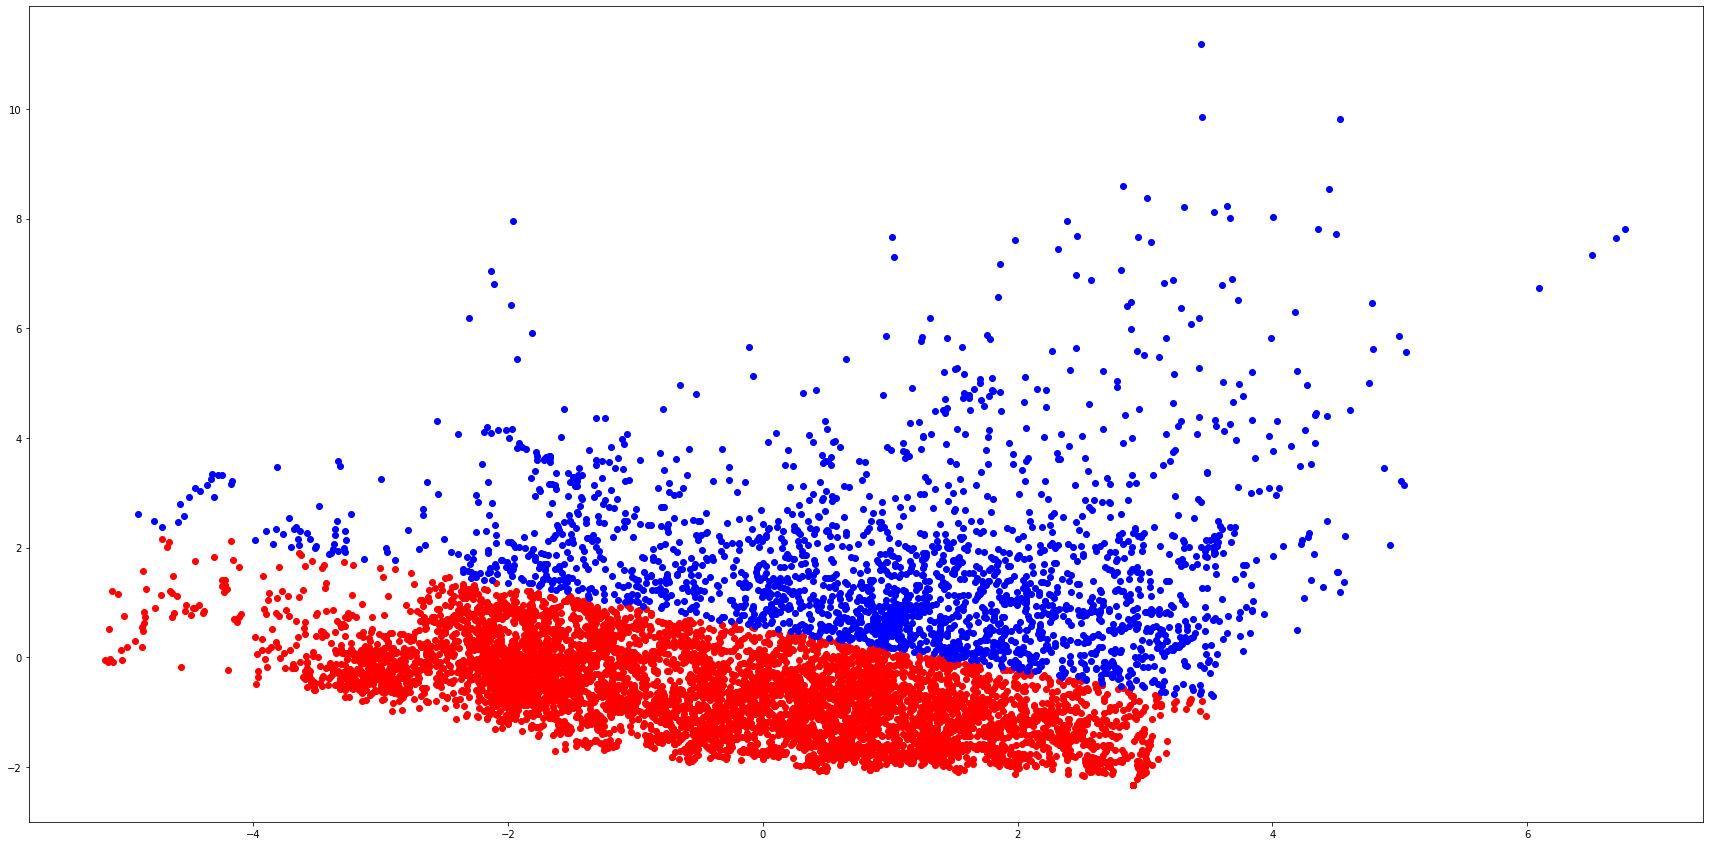

In [8]:
gmm = mixture.GaussianMixture(
        n_components=2, covariance_type="full"
    )
gmm.fit(X)
labels = gmm.predict(X)

#filter rows of original data (https://www.askpython.com/python/examples/plot-k-means-clusters-python)
filtered_label0 = pcaDF[labels == 0]
filtered_label1 = pcaDF[labels == 1]

#Plotting the results (https://www.askpython.com/python/examples/plot-k-means-clusters-python)
plt.figure(figsize=(30, 15))
plt.scatter(filtered_label0['principal component 1'] , filtered_label0['principal component 2'], color = 'red')
plt.scatter(filtered_label1['principal component 1'] , filtered_label1['principal component 2'] , color = 'blue')


### SVM Cross-Validation

In [21]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import sys

# Initialize arrays to keep track of performance
svm_accuracy = []
svm_recall = []
svm_precision = []
svm_f1scores = []
svm_confusion_matrices = []

kfold = StratifiedKFold(5, True, 1)
# Conduct 5-fold cross-validation
for train_index, test_index in kfold.split(trainDF, train_labels):
    
    # Reset model 
    # kernel, C and gamma were chosen based on accuracy trial and error 
    model = svm.SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma='auto') 
    
    # Get training data and test data
    train_data, test_data = trainDF.loc[train_index], trainDF.loc[test_index]
    # Source ground truth labels
    actual_training_labels = train_labels.loc[train_index].to_numpy()
    actual_test_labels = train_labels.loc[test_index].to_numpy()
    np.set_printoptions(threshold=sys.maxsize)

    # Fit and predict
    model.fit(train_data, actual_training_labels)
    svm_labels = model.predict(test_data)
    
    # Calculate accuracy, recall, precision, and f1 scores
    svm_accuracy_score = metrics.accuracy_score(actual_test_labels, svm_labels)
    svm_recall_score = metrics.recall_score(actual_test_labels, svm_labels, average="macro")
    svm_precision_score = metrics.precision_score(actual_test_labels, svm_labels, average="macro")
    svm_f1_score = metrics.f1_score(actual_test_labels, svm_labels, average="macro")
    
    # Store the results in respective arrays
    svm_accuracy.append(svm_accuracy_score)
    svm_recall.append(svm_recall_score)
    svm_precision.append(svm_precision_score)
    svm_f1scores.append(svm_f1_score)
    svm_confusion_matrices.append(np.asarray(metrics.confusion_matrix(actual_test_labels, svm_labels)))

### Performance of Cross-Validation

The average accuracy score is:  0.9269850642959887
The average recall score is:  0.9238961176613099
The average precision score is:  0.9199688119455773
The average f1 score is:  0.921752553883827


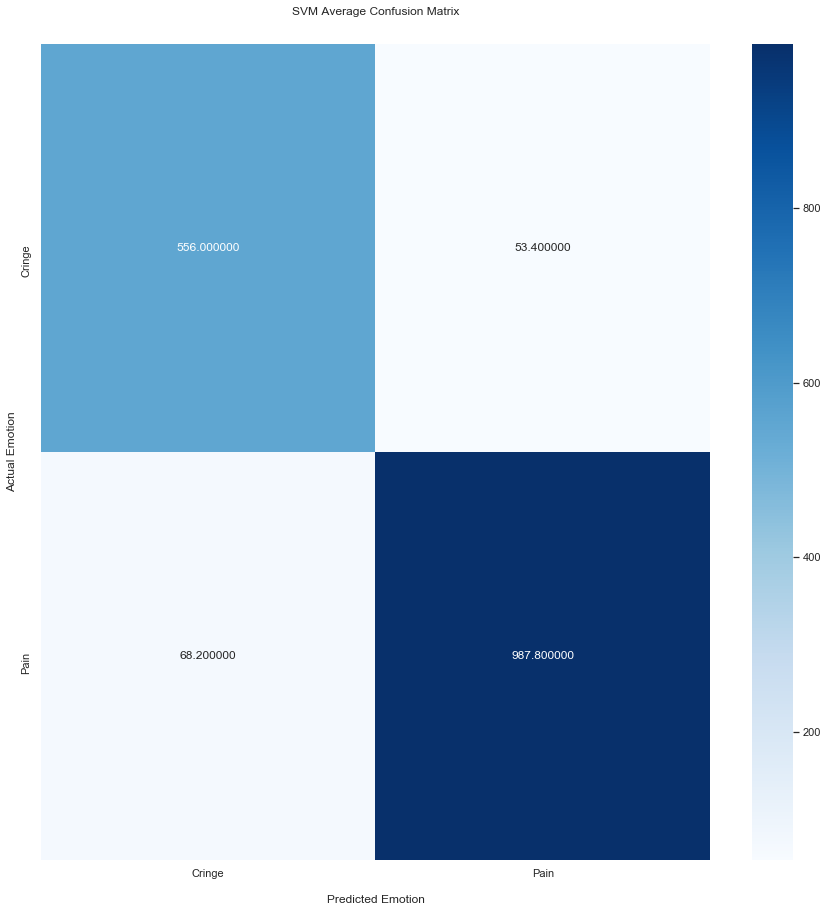

In [22]:
# https://seaborn.pydata.org/#:~:text=Seaborn%20is%20a%20Python%20data,introductory%20notes%20or%20the%20paper.
# https://docs.python.org/3/library/statistics.html
# https://matplotlib.org/
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average scores 
average_svm_accuracy = statistics.mean(svm_accuracy)
average_svm_recall = statistics.mean(svm_recall)
average_svm_precision = statistics.mean(svm_precision)
average_svm_f1 = statistics.mean(svm_f1scores)

# Output average scores
print("The average accuracy score is: ", average_svm_accuracy)
print("The average recall score is: ", average_svm_recall)
print("The average precision score is: ", average_svm_precision)
print("The average f1 score is: ", average_svm_f1)

# Initialize a 7x7 2D array for getting CM average
summed_svm_cm = np.zeros(4).reshape(2,2)

# Sum values of matrix for getting CM average
for matrix in svm_confusion_matrices: 
    summed_svm_cm = np.add(summed_svm_cm, matrix)

average_svm_cm = np.divide(summed_svm_cm, 5) 
matrix_labels = ["Cringe", "Pain"]

# Code below used from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=import%20seaborn%20as%20sns%0Aimport,the%20Confusion%20Matrix.%0Aplt.show()
sns.set(rc = {'figure.figsize':(15,15)})
ax = sns.heatmap(average_svm_cm, fmt="f", annot=True, cmap='Blues')

ax.set_title('SVM Average Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion')
ax.set_ylabel('Actual Emotion');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(matrix_labels)
ax.yaxis.set_ticklabels(matrix_labels)

# fix for mpl bug that cuts off top/bottom of seaborn viz https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
## Display the visualization of the Confusion Matrix.
plt.show()

### Test Performance

The accuracy score is:  0.94716618635927
The recall score is:  0.9453677126566076
The precision score is:  0.9438183680568977
The F1 score is:  0.9445770606820927


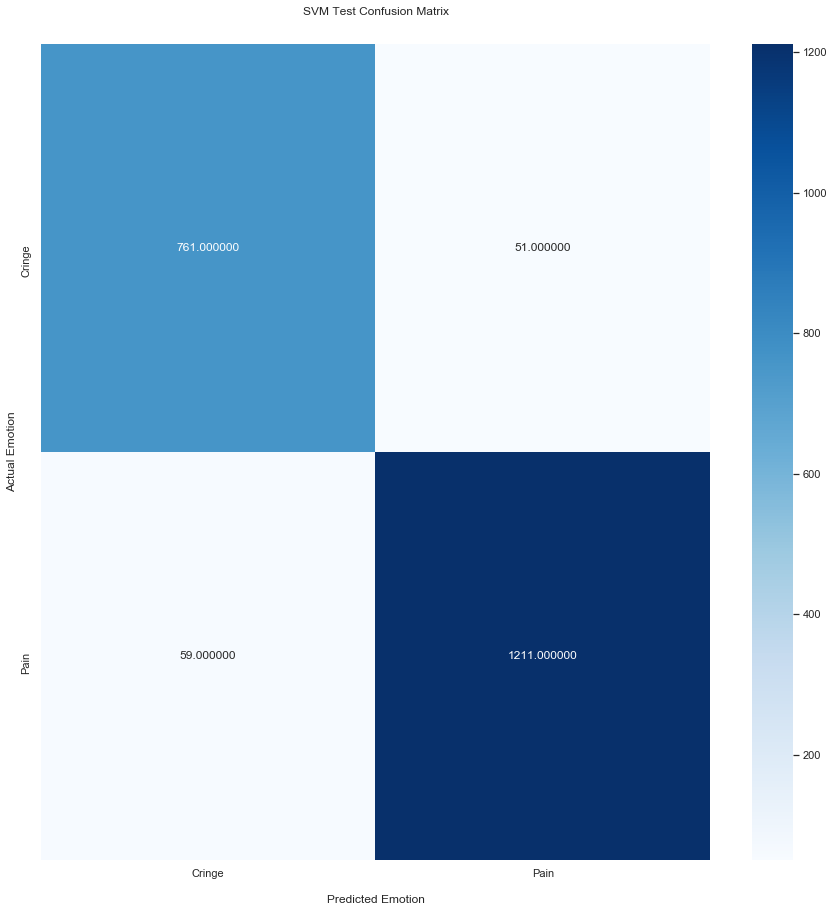

In [20]:
# Performance on Test Data
model = svm.SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma='auto')

model.fit(trainDF, train_labels)
results = model.predict(testDF)

test_accuracy = metrics.accuracy_score(test_labels, results)
test_recall = metrics.recall_score(test_labels, results, average="macro")
test_precision = metrics.precision_score(test_labels, results, average="macro")
test_f1score =  metrics.f1_score(test_labels, results, average="macro")
test_confusion = metrics.confusion_matrix(test_labels, results)

print("The accuracy score is: ", test_accuracy)
print("The recall score is: ", test_recall)
print("The precision score is: ", test_precision)
print("The F1 score is: ", test_f1score)
# Code below used from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=import%20seaborn%20as%20sns%0Aimport,the%20Confusion%20Matrix.%0Aplt.show()
sns.set(rc = {'figure.figsize':(15,15)})
ax = sns.heatmap(test_confusion, fmt="f", annot=True, cmap='Blues')

ax.set_title('SVM Test Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion')
ax.set_ylabel('Actual Emotion');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(matrix_labels)
ax.yaxis.set_ticklabels(matrix_labels)

# fix for mpl bug that cuts off top/bottom of seaborn viz https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
## Display the visualization of the Confusion Matrix.
plt.show()